Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 D. M. Phelps

# Backward Facing Step and Non Symmetrical Domains

## Background

So far in our lectures we have only discussed symmetical domains. That is to say we have dealt with boundries which are neat and orderly. In this lecture we will discuss how to incorperate steps and cavities into our domains. 

Many engineering problems studied today involve uniquely defined boundries. In this notebook we will look at the Backward Facing Step. The Backward Facing Step problem is a commonly studied problem which creates seperated flow and turbulance. It is defined as having free stream flow passing over a sharp ridge the flow will seperate at the ridge and reattach down stream.


## Equations

The governing equations for this flow will be Navier Stokes in two dimension and  an equation to relate pressure to velocity.


N.S. X direction
$$
\frac{\partial u}{\partial t} 
+u\frac{\partial u}{\partial x}
+v\frac{\partial u}{\partial y}
=
-\frac{1}{\rho}\frac{\partial p}{\partial x}
+
\nu\left(
\frac{\partial^2 u}{\partial x^2}
+
\frac{\partial^2 u}{\partial y^2}\right)
$$

N.S. Y direction
$$
\frac{\partial v}{\partial t} 
+v\frac{\partial v}{\partial x}
+u\frac{\partial v}{\partial y}
=
-\frac{1}{\rho}\frac{\partial p}{\partial y}
+
\nu\left(
\frac{\partial^2 v}{\partial y^2}
+
\frac{\partial^2 v}{\partial x^2}\right)
$$

Pressure
$$
\frac{\partial^2 p}{\partial x^2}
+
\frac{\partial^2 p}{\partial y^2}
=
-
\rho\left(
\frac{\partial u}{\partial x}
\frac{\partial u}{\partial x}
+
2
\frac{\partial u}{\partial x}
\frac{\partial v}{\partial y}
+
\frac{\partial v}{\partial y}
\frac{\partial v}{\partial y}
\right)
$$


## Boundry Conditions

Next we will create our domain and define all parameters we will need later in the solver. 

First lets think about our physical space. The step/wall will have a no slip condition. We will only have free stream flow in the X direction. finally we will be sloving for the fully developed flow.

*No slip => u,v = 0 along the walls

*Free stream only in x => u = 1 , v = 0 for all open boundries

*Homogenous neumann boundry conditions will be used for pressure.


In [8]:
import numpy
from matplotlib import pyplot, cm 
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [9]:
#spatial parameters
nx = 101
ny = 101
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace (0,10,nx)
y = numpy.linspace (0,10,ny)
X , Y = numpy.meshgrid(x,y)
H = int(.25*(ny-1))  #height of step as fraction of ny
L = int(.1*(nx -1))  #length of the step as a fraction of nx

#physical constants
rho = 1
nu = 1 

#temporal parameters 
nt = 10 #may need to vary to achieve steady state 
dt = .0001 #

#initial velocity and pressure arrays
p = numpy.zeros((ny,nx))
u = numpy.zeros((ny,nx))
v = numpy.zeros((ny,nx))
limit = 0.01 # limit for how accurate our pressure poisoon equation needs to be

Now lets write functions to impose our boundry conditions

In [10]:
def Vel_BC(u,v,H,L):
    """ returns u and v with correct boundry conditions imposed
    
    Parameters
    ----------
    u : array of floats 
        array containing u at given time
    v : array of floats 
        array containing v at given time
    H : Interger
        Interger representing step hieght
    L : Interger 
        Interger representing the length of the step
    
    Returns
    -------
    u : array of floats 
        array containing u at given time with BC imposed
    v : array of floats 
        array containing v at given time with BC imposed
    """
    
    #impose simple boundry conditions then correct for the step.
    # u,v bottom of domain
    u[0,:] = 0
    v[0,:] = 0
    #u,v left side of domain
    u[:,0] = 1
    v[:,0] = 0
    #u,v top of domain
    u[-1,:] = 1
    v[-1,:] = 0
     #u,v right side of domain
    u[1:,-1] = 1
    v[:,-1] = 0
    # now we correct for the step
    # u,v for the step
    u[0:H,0:L] = 0
    v[0:H,0:L] = 0 
    
    return u , v

In [11]:
def Pres_BC(p,H,L):
    """ returns P with correct boundry conditions imposed
    
    Parameters
    ----------
    p : array of floats 
        array containing p at given time
    H : Interger
        Interger representing step hieght
    L : Interger 
        Interger representing the length of the step
    
    Returns
    -------
    p : array of floats 
        array containing P at given time with BC imposed
    """
   
    #impose simple boundry conditions then correct for the step.
    # P bottom of domain
    p[0 ,: ] = p[ 1, :] 
    #P left side of domain
    p[: ,0 ] = p[ :, 1]
    #u,v top of domain
    p[-1,: ] = p[-2, :] 
    #u,v right side of domain
    p[: ,-1] = p[: ,-2]
    # now we correct for the step
    # Pfor the step
    p[H  ,0:L] = p[H+1,0:L]
    p[H-1,0:L] = p[H  ,0:L]
    p[H-2,0:L] = p[H-1,0:L]
    p[0:H,L  ] = p[0:H,L+1]
    p[0:H,L-1] = p[0:H,L  ]
    p[0:H,L-2] = p[0:H,L-1]
    
    return p

## Numerical Method

describe the discritization scheme

## Solving the problem

Now that we a our boundry conditions established lets make a solver. 
We will start with a function to solve to pressure part of this problem. Then make solver than incorporates that function and solves the complete problem.

In [15]:
def Pressure(p,u,v,dx,dy,limit,rho):
    """ solves pressure poisson 
    
    Parameters
    ----------
    p     : array of floats 
            array containing P at given time
    u     : array of floats 
            array containing u at given time
    v     : array of floats 
            array containing v at given time 
    dx    : float
            defines to grid spacing in x 
    dy    : float
            defines to grid spacing in y
    limit : float
            defines how percise the pressure poisson needs to be solved
    rho   : float 
            physical constant for density
    
    
    Returns
    -------
    p : array of floats 
        array containing p after pressure poisson has been solved
    """
   
    pnorm = 1
    while pnorm > limit:
        
        pn = p.copy()
        p[1:-1,1:-1] = (((pn[1:-1,2:] + pn[1:-1,:-2])*dy**2   \
                     +   (pn[2:,1:-1] + pn[:-2,1:-1]))*dx**2  \
                     / (2*(dx**2 +dy**2)))                     \
                     - ((rho*dx**2*dy**2)/(2*(dx**2 + dy**2)))  \
                     * ((1/dt)*(((u[1:-1,2:] - u[1:-1,0:-2])/(2*dx)) \
                     +          ((v[2:,1:-1] - v[0:-2,1:-1])/(2*dy))) \
                     -          ((u[1:-1,2:] - u[1:-1,0:-2])/(2*dx))\
                     *          ((u[1:-1,2:] - u[1:-1,0:-2])/(2*dx))\
                   -2*         (((u[2:,1:-1] - u[0:-2,1:-1])/(2*dy))\
                     *          ((v[1:-1,2:] - v[1:-1,0:-2])/(2*dx)))\
                     -          ((v[2:,1:-1] - v[0:-2,1:-1])/(2*dy)) \
                     *          ((v[2:,1:-1] - v[0:-2,1:-1])/(2*dy))) 
                    
        pn = Pres_BC(pn.copy(),H,L)
        pnorm = numpy.sum(numpy.abs(pn-p))
                        
    return p

In [16]:
def BFS(u,v,p,dx,dy,dt,limit,rho,nu,nt):
    """ solves backward facing step 
    
    Parameters
    ----------
    u     : array of floats 
            array containing u at given time
    v     : array of floats 
            array containing v at given time 
    p     : array of floats 
            array containing P at given time                       
    dx    : float
            defines to grid spacing in x 
    dy    : float
            defines to grid spacing in y
    dt    : float
            defines step size in time            
    limit : float
            defines how percise the pressure poisson needs to be solved
    rho   : float 
            physical constant for density
    nu    : float 
            physical constant for viscosity
    nt    : float
            defines how long in times to solver will work forward
    
    Returns
    -------
    u : array of floats 
        array containing u after the backward facing step solver has worked forward to time nt
    v : array of floats 
        array containing v after the backward facing step solver has worked forward to time nt
    p : array of floats 
        array containing p after the backward facing step solver has worked forward to time nt    
    """
    
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        p = Pressure(p.copy(),u.copy(),v.copy(),dx,dy,limit,rho)
        u[1:-1,1:-1] = ( un[1:-1,1:-1]
                       - un[1:-1,1:-1]*(dt/dx)
                       *(un[1:-1,1:-1]-un[1:-1,0:-2])
                       - vn[1:-1,1:-1]*(dt/dy) 
                       *(un[1:-1,1:-1]-un[0:-2,1:-1])
                       -(dt/(2*rho*dx))
                       *( p[1:-1,2:  ]- p[1:-1,0:-2])  
                    +nu*((dt/dx**2) 
                       *(un[1:-1,2:  ]-2*un[1:-1,1:-1]+un[1:-1,0:-2])
                       +(dt/dy**2)
                       *(un[2:  ,1:-1]-2*un[1:-1,1:-1]+un[0:-2,1:-1])))
        
                         
            
        v[1:-1,1:-1] = ( vn[1:-1,1:-1]
                       - un[1:-1,1:-1]*(dt/dx)
                       *(vn[1:-1,1:-1]-vn[1:-1,0:-2])
                       - vn[1:-1,1:-1]*(dt/dy) 
                       *(vn[1:-1,1:-1]-vn[0:-2,1:-1])
                       -(dt/(2*rho*dx))
                       *( p[1:-1,2:  ]- p[1:-1,0:-2])  
                    +nu*((dt/dx**2) 
                       *(vn[1:-1,2:  ]-2*vn[1:-1,1:-1]+vn[1:-1,0:-2])
                       +(dt/dy**2)
                       *(vn[2:  ,1:-1]-2*vn[1:-1,1:-1]+vn[0:-2,1:-1]))) 
        
        u,v = Vel_BC(u.copy(),v.copy(),H,L)
        return u,v,p
                        
                            

Now lets run our code with the number of time steps we guessed.

In [17]:
u,v,p = BFS(u.copy(),v.copy(),p.copy(),dx,dy,dt,limit,rho,nu,nt)

Lets get a plot of what our velocity field looks like 

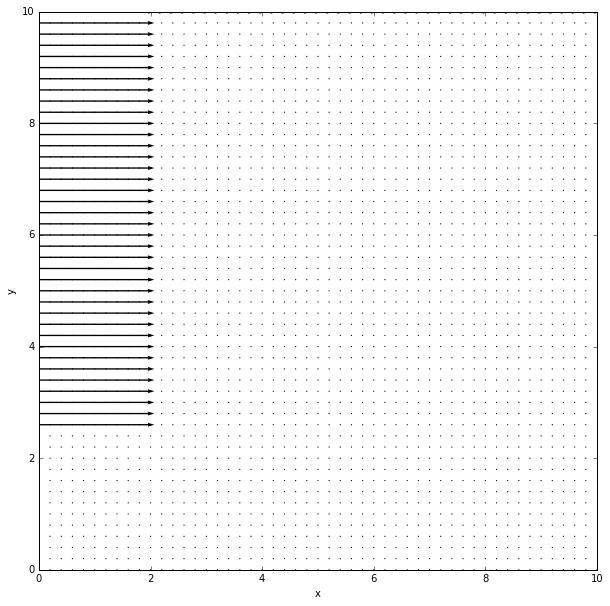

In [18]:
fig = pyplot.figure(figsize=(10,10), dpi = 100)
pyplot.quiver(X[::2,::2],Y[::2,::2],u[::2,::2],v[::2,::2])
pyplot.xlabel('x')
pyplot.ylabel('y')

## References

list of references used to create this notebook

http://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/

In [13]:
a= (((v[2:,1:-1] -v[0:-2,1:-1])/(2*dy))*((v[2:,1:-1] -v[0:-2,1:-1])/(2*dy)))

In [14]:
a.shape

(99, 99)